In [10]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import isnan, when, count, col, lit, udf
from pyspark.sql.types import *
from pyspark.sql.window import Window
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.inspection import partial_dependence, plot_partial_dependence, permutation_importance
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
import pandas as pd 
import numpy as np 
import re
import scipy.stats as stats
import matplotlib.pyplot as plt
import pickle

spark = SparkSession.builder.appName("CSVLoad").getOrCreate()

## Load Dataset from Parquet

In [2]:
df_bank=spark.read.parquet("spark-warehouse/bank_impute_clean")
print(df_bank.count())
print(df_bank.schema.names)
print(df_bank.printSchema())

41188
['age', 'job', 'marital', 'education', 'default', 'housing', 'contact', 'campaign', 'previous', 'poutcome', 'cons_price_idx', 'cons_conf_idx', 'nr_employed', 'y']
root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)

None


## Prepare Pipeline

In [11]:
## Train-test split

target = 'y'
X=df_bank.toPandas().drop([target],axis=1)
Y=df_bank.toPandas()[target].apply(lambda x: 1 if x=='yes' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    random_state=9000, 
                                                    test_size=0.2,
                                                    stratify=Y)

## Prepare countinuous, ordinal and categorical feature sets and levels

# continuous
numeric_features = ['age','campaign','previous',
                    'cons_price_idx','cons_conf_idx','nr_employed']
numeric_transformer = Pipeline(
    steps=[('scaler', StandardScaler())]
)

# ordinal
ordinal_features = ['education','default','housing','poutcome']
ordinal_transformer = OrdinalEncoder()

#levels for ordinals
cat_education_lvl = [['university.degree','professional.course','high.school', 
                      'basic.9y','basic.6y','basic.4y','illiterate']]
cat_default_lvl = [['no','unknown']]
cat_housing_lvl = [['yes','no']]
cat_poutcome_lvl = [['success','nonexistent','failure']]

# categorical
cat_job = [[i for i in X['job'].unique()]]
cat_marital = [[i for i in X['marital'].unique()]]
cat_contact = [[i for i in X['contact'].unique()]]

categorical_transformer = OneHotEncoder()

# Prepare scaler, preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('education',OrdinalEncoder(categories=cat_education_lvl), ['education']),
        ('default',OrdinalEncoder(categories=cat_default_lvl), ['default']),
        ('housing',OrdinalEncoder(categories=cat_housing_lvl), ['housing']),
        ('poutcome',OrdinalEncoder(categories=cat_poutcome_lvl), ['poutcome']),
        ('job', OneHotEncoder(categories=cat_job), ['job']),
        ('marital', OneHotEncoder(categories=cat_marital), ['marital']),
        ('contact', OneHotEncoder(categories=cat_contact), ['contact'])
    ]
)

## save prepocessor

pickle.dump(preprocessor, open("preprocessor", "wb"))


# Prepare transformed column names

transformers = preprocessor.transformers

def get_features_names(transformer):
    transformed_cols = []
    steps = range(len(transformer))
    for step in steps:
        if step==0:
            num_cols = transformers[step][-1]
            transformed_cols = transformed_cols + [i for i in num_cols]
        elif type(transformers[step][1]) == type(OrdinalEncoder()):
            ordinal_cols = transformers[step][-1]
            transformed_cols = transformed_cols + [i for i in ordinal_cols]
        else:
            new_cols = [i+'_'+j for j in transformers[step][1].categories[0] for i in transformers[step][-1]]
            transformed_cols = transformed_cols + [i for i in new_cols]
    return transformed_cols

transformed_cols = get_features_names(transformers)

# A. Gradient Boosting Classifier

In [42]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('clf',GradientBoostingClassifier())])

k_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

# Hyperparameters for GradientBoostingClassifer

param_grid = {'clf__n_estimators': [1000],
            'clf__max_depth': [3],
            'clf__min_samples_leaf': [8,10],
            'clf__learning_rate': [0.1,0.05,0.03,0.01]}

gbc_grid = GridSearchCV(pipe, param_grid = param_grid, scoring='accuracy',
                          cv = k_fold, n_jobs = -1, verbose = 1)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.

gbc_grid.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'campaign',
                                                                          'previous',
                                                                          'cons_price_idx',
                                                                          'cons_conf_idx',
                                                                          'nr_employed']),
                                                   

## Key measurements of Gradient Boosting Classifier

In [43]:
def get_kpis(pipeline):

    # Print Coefficient of determination

    print("Model Accuracy: {:.3f}".format(pipeline.score(X_test, y_test)))

    # Calculat Accuracy, Precision, Recall, F1 Score

    metrics = precision_recall_fscore_support(y_test, pipeline.predict(X_test))

    print("Precision of postive cases: {:.2f}".format(metrics[0][-1]))
    print("Recall of postive cases: {:.2f}".format(metrics[1][-1]))
    print("F1 Score of postive cases: {:.2f}".format(metrics[2][-1]))

get_kpis(gbc_grid)

Model Accuracy: 0.899
Precision of postive cases: 0.63
Recall of postive cases: 0.24
F1 Score of postive cases: 0.35


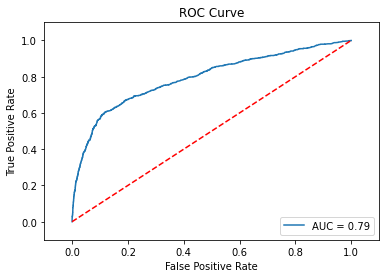

In [44]:
## ROC Curve

def plot_roc_curve(pipeline):

    y_preds = gbc_grid.predict_proba(X_test)

    # take the second column because the classifier outputs scores for
    # the 0 class as well
    preds = y_preds[:,1]

    # fpr means false-positive-rate
    # tpr means true-positive-rate
    fpr, tpr, _ = roc_curve(y_test, preds)

    auc_score = auc(fpr, tpr)

    # clear current figure
    plt.clf()

    plt.title('ROC Curve')
    plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

    # it's helpful to add a diagonal to indicate where chance 
    # scores lie (i.e. just flipping a coin)
    plt.plot([0,1],[0,1],'r--')

    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.legend(loc='lower right')
    plt.show()

    return y_preds

y_preds = plot_roc_curve(gbc_grid)

average response rate:  0.11264870114105366
Maximum KS: 0.42


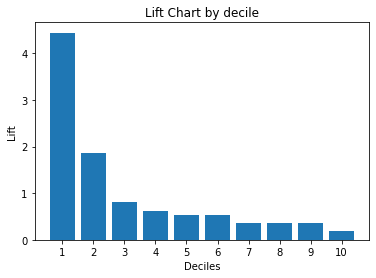

In [45]:
## Lift Chart and KS

def lift (test, pred, bins):

    res = pd.DataFrame(np.column_stack((test, pred)),
                       columns=['Target','PR_0', 'PR_1'])

    res['scr_grp'] = pd.qcut(res['PR_0'], bins, labels=False)+1

    crt = pd.crosstab(res.scr_grp, res.Target).reset_index()
    crt = crt.rename(columns= {'Target':'Np',0.0: 'Negatives', 1.0: 'Positives'})

    G = crt['Positives'].sum()
    B = crt['Negatives'].sum()
   
    avg_resp_rate = G/(G+B)

    crt['resp_rate'] = round(crt['Positives']/(crt['Positives']+crt['Negatives']),2)
    crt['lift'] = round((crt['resp_rate']/avg_resp_rate),2)
    crt['rand_resp'] = 1/bins
    crt['cmltv_p'] = round((crt['Positives']).cumsum(),2)
    crt['cmltv_p_perc'] = round(((crt['Positives']/G).cumsum())*100,1)
    crt['cmltv_n'] = round((crt['Negatives']).cumsum(),2)  
    crt['cmltv_n_perc'] = round(((crt['Negatives']/B).cumsum())*100,1)   
    crt['cmltv_rand_p_perc'] = (crt.rand_resp.cumsum())*100
    crt['cmltv_resp_rate'] = round(crt['cmltv_p']/(crt['cmltv_p']+crt['cmltv_n']),2)   
    crt['cmltv_lift'] = round(crt['cmltv_resp_rate']/avg_resp_rate,2)
    crt['KS']=round(crt['cmltv_p_perc']-crt['cmltv_rand_p_perc'],2)
    crt = crt.drop(['rand_resp','cmltv_p','cmltv_n',], axis=1)
    
    print('average response rate: ' , avg_resp_rate)
    return crt

ModelLift=lift(y_test,y_preds,10)
# print(ModelLift)

print("Maximum KS: {:.2f}".format(ModelLift['KS'].max()/100.0))

plt.bar(ModelLift['scr_grp'], ModelLift['lift'])
plt.title('Lift Chart by decile')
plt.xlabel('Deciles')
plt.xticks(range(1,11))
plt.ylabel('Lift')
plt.show()

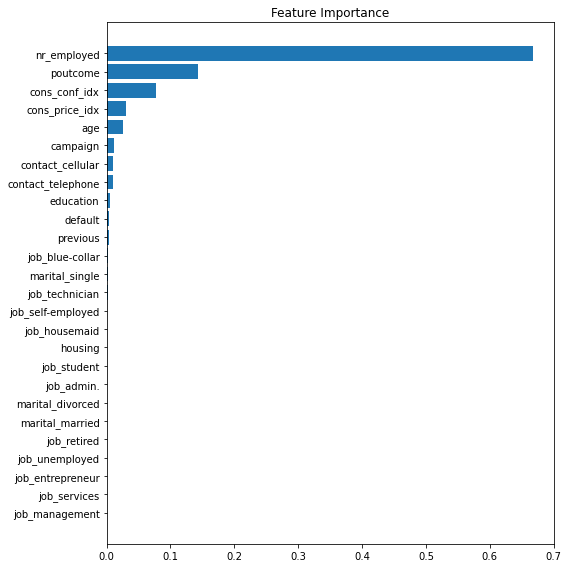

In [46]:
def get_feature_importance(clf):
    '''Get Feature importance data using feature_importances_ attribute'''
    feature_importance = clf.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    fig = plt.figure(figsize=(8, 8))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(transformed_cols)[sorted_idx])
    plt.title('Feature Importance')
    fig.tight_layout()

get_feature_importance(gbc_grid.best_estimator_.named_steps['clf'])

AxesSubplot(0.125,0.125;0.0945122x0.755)
contact_cellular
AxesSubplot(0.238415,0.125;0.0945122x0.755)
campaign


/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


AxesSubplot(0.351829,0.125;0.0945122x0.755)
age
AxesSubplot(0.465244,0.125;0.0945122x0.755)
cons_price_idx


/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


AxesSubplot(0.578659,0.125;0.0945122x0.755)
cons_conf_idx
AxesSubplot(0.692073,0.125;0.0945122x0.755)
poutcome


/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


AxesSubplot(0.805488,0.125;0.0945122x0.755)
nr_employed


/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


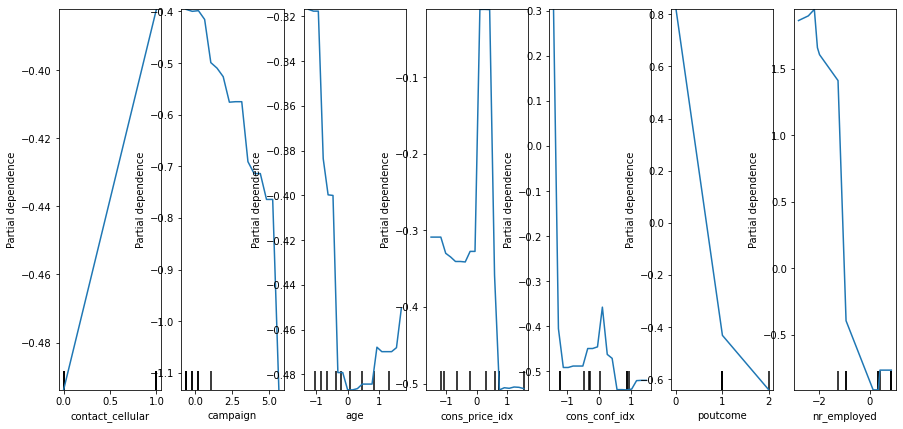

In [56]:
def get_partial_dependence(pipeline,top_n_preds=5):
    ''' see partial dependence of top n chart'''
    preprocessor = pipeline.best_estimator_.named_steps['preprocessor']
    clf = pipeline.best_estimator_.named_steps['clf']

    X_test_for_plot = pd.DataFrame(preprocessor.transform(X_test))
    X_test_for_plot.columns = transformed_cols

    feature_importance = clf.feature_importances_
    sorted_idx = np.argsort(feature_importance)

    fig, axes = plt.subplots(1,top_n_preds, figsize=(15,top_n_preds))
    for ax,feat in zip(axes,np.array(transformed_cols)[sorted_idx][-top_n_preds:]):
        print(ax)
        print(feat)
        plot_partial_dependence(clf,
        X_test_for_plot,
        [feat],
        n_jobs=-1,
        grid_resolution=20,
        ax=ax)
    plt.show()

get_partial_dependence(gbc_grid,7)


# B. RandomForest Classifier

In [29]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('clf',RandomForestClassifier())])

k_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

# Hyperparameters for GradientBoostingClassifer

param_grid = {'clf__n_estimators': [1000],
            'clf__max_depth': [4,5,6],
            'clf__max_features':['sqrt'],
            'clf__min_samples_leaf': [8,10]}

rf_grid = GridSearchCV(pipe, param_grid = param_grid, scoring='accuracy',
                          cv = k_fold, n_jobs = -1, verbose = 1)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.

rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'campaign',
                                                                          'previous',
                                                                          'cons_price_idx',
                                                                          'cons_conf_idx',
                                                                          'nr_employed']),
                                                   

## Key measurements of Random Forest Classifier

Model Accuracy: 0.898
Precision of postive cases: 0.68
Recall of postive cases: 0.19
F1 Score of postive cases: 0.29


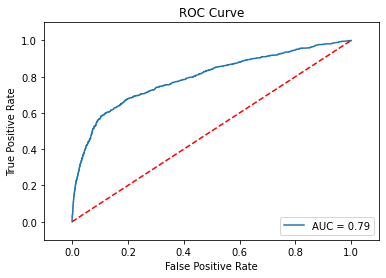

In [30]:
get_kpis(rf_grid)
y_preds = plot_roc_curve(rf_grid)

average response rate:  0.11264870114105366
Maximum KS: 0.42


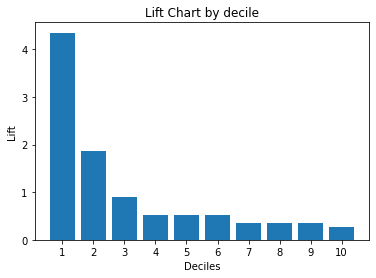

In [31]:
ModelLift=lift(y_test,y_preds,10)
# print(ModelLift)

print("Maximum KS: {:.2f}".format(ModelLift['KS'].max()/100.0))

plt.bar(ModelLift['scr_grp'], ModelLift['lift'])
plt.title('Lift Chart by decile')
plt.xlabel('Deciles')
plt.xticks(range(1,11))
plt.ylabel('Lift')
plt.show()

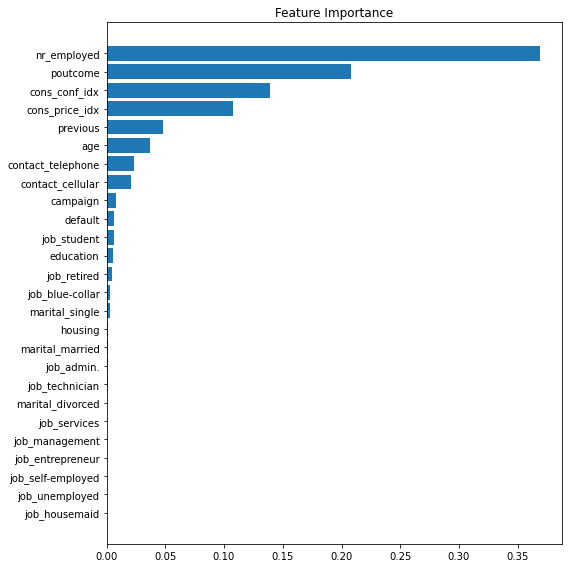

In [34]:
get_feature_importance(rf_grid.best_estimator_.named_steps['clf'])

AxesSubplot(0.125,0.125;0.0945122x0.755)
contact_telephone


/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


AxesSubplot(0.238415,0.125;0.0945122x0.755)
age


/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sk

AxesSubplot(0.351829,0.125;0.0945122x0.755)
previous


/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sk

AxesSubplot(0.465244,0.125;0.0945122x0.755)
cons_price_idx


/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sk

AxesSubplot(0.578659,0.125;0.0945122x0.755)
cons_conf_idx


/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sk

AxesSubplot(0.692073,0.125;0.0945122x0.755)
poutcome


/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


AxesSubplot(0.805488,0.125;0.0945122x0.755)
nr_employed


/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/bhaddhadon/anaconda3/envs/py39/lib/python3.9/site-packages/sk

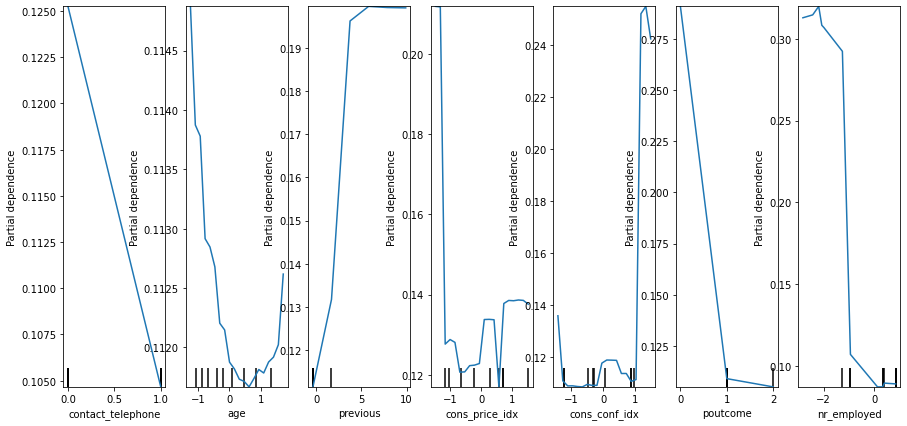

In [57]:
get_partial_dependence(rf_grid,top_n_preds=7)